In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
os.chdir("D:\Sales full project\sales_customer_segmentation")

In [3]:
os.getcwd()

'D:\\Sales full project\\sales_customer_segmentation'

In [4]:
cst_df=pd.read_csv("DimCustomer.csv")
dt_df=pd.read_csv("DimDate.csv")
pd_df=pd.read_csv("DimProduct.csv")
pdc_df=pd.read_csv("DimProductCategory.csv")
pdsc_df=pd.read_csv("DimProductSubCategory.csv")
int_sales=pd.read_csv("FactInternetSales.csv")

## Data Cleaning

In [5]:
drop_list = ['GeographyKey','CustomerAlternateKey', 'Title', 'FirstName', 'MiddleName', 'LastName',"FrenchEducation",
 'NameStyle',"Suffix","EmailAddress","SpanishOccupation","FrenchOccupation","Phone","NumberCarsOwned","AddressLine1","AddressLine2","SpanishEducation"]

drop_list_pd=['WeightUnitMeasureCode', 'SizeUnitMeasureCode', 'SpanishProductName', 'FrenchProductName', 'ListPrice', 'Size',
 'SizeRange', 'Weight', 'DaysToManufacture', 'ProductLine', 'DealerPrice', 'Class', 'Style', 'ModelName', 'LargePhoto',
 'FrenchDescription', 'ChineseDescription', 'ArabicDescription', 'HebrewDescription', 'ThaiDescription', 'GermanDescription', 'JapaneseDescription',
 'TurkishDescription', 'StandardCost', 'FinishedGoodsFlag', 'Color', 'SafetyStockLevel', 'ReorderPoint', 'Status', 'StartDate', 'EndDate']

drop_product_category=["ProductCategoryAlternateKey","SpanishProductCategoryName","FrenchProductCategoryName"]
drop_product_subc=["ProductSubcategoryAlternateKey","ProductSubcategoryAlternateKey","SpanishProductSubcategoryName","FrenchProductSubcategoryName"]
drop_int_sales=["CarrierTrackingNumber","CustomerPONumber","ProductStandardCost","TotalProductCost","PromotionKey","CurrencyKey","SalesTerritoryKey",
               "OrderDate","DueDate","ShipDate","RevisionNumber"]


In [6]:
cst_df=cst_df.drop(drop_list,axis=1)

pd_df=pd_df.drop(drop_list_pd,axis=1)

pdsc_df=pdsc_df.drop(drop_product_subc,axis=1)

pdc_df=pdc_df.drop(drop_product_category,axis=1)

int_sales=int_sales.drop(drop_int_sales,axis=1)

### Sales data

In [7]:
int_sales.head()

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,SalesOrderNumber,SalesOrderLineNumber,OrderQuantity,UnitPrice,ExtendedAmount,UnitPriceDiscountPct,DiscountAmount,SalesAmount,TaxAmt,Freight
0,310,20101229,20110110,20110105,21768,SO43697,1,1,3578.2700,3578.2700,0,0,3578.2700,286.2616,89.4568
1,346,20101229,20110110,20110105,28389,SO43698,1,1,3399.9900,3399.9900,0,0,3399.9900,271.9992,84.9998
2,346,20101229,20110110,20110105,25863,SO43699,1,1,3399.9900,3399.9900,0,0,3399.9900,271.9992,84.9998
3,336,20101229,20110110,20110105,14501,SO43700,1,1,699.0982,699.0982,0,0,699.0982,55.9279,17.4775
4,346,20101229,20110110,20110105,11003,SO43701,1,1,3399.9900,3399.9900,0,0,3399.9900,271.9992,84.9998


Changing the Numeric data type of the date column to Date

In [8]:
def date_conversion(x):
    y=pd.to_datetime(x,format="%Y%m%d")
    return y

In [9]:
int_sales[["OrderDateKey","DueDateKey","ShipDateKey"]]=int_sales[["OrderDateKey","DueDateKey","ShipDateKey"]].apply(date_conversion)

Checking the number of unique values in each columns of the Sales table

In [10]:
int_cols=int_sales.select_dtypes(exclude="O").columns
temp_df=pd.DataFrame()
for col in int_cols:
    temp_df.loc[1,col]=int_sales[col].nunique()

In [11]:
temp_df

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,SalesOrderLineNumber,OrderQuantity,UnitPrice,ExtendedAmount,UnitPriceDiscountPct,DiscountAmount,SalesAmount,TaxAmt,Freight
1,158.0,1124.0,1124.0,1124.0,18484.0,8.0,1.0,42.0,42.0,1.0,1.0,42.0,42.0,42.0


In [12]:
int_sales["SalesOrderNumber"].nunique()

27659

There are 158 products for 18484 customers where the total number of transcation carried out  27659 within the span of 3 Years.
        (i.e., 2010-12-29 to 2014-01-28)


Checking if there is any Variation between UnitPrice & ExtendedAmount using statistical  Kruskal Wallis test In order to eliminate one among them.

Reason for choosing KrushalWallis Test as it is performed on non parametric data.

In [13]:
Var_test=stats.kruskal(int_sales["UnitPrice"],int_sales["ExtendedAmount"])
if Var_test[-1]>0.05:
    print("Null Hypothesis is accepted the as the pvalue is greater than 0.05")
else:
    print("We reject the Null Hypothesis")

Null Hypothesis is accepted the as the pvalue is greater than 0.05


From the temp_df it is very clear that the company has not provided any kind of discounts on any of there products.
so we can drop UnitPriceDiscountPct and DiscountAmount.

As they have not offered any discounts SalesAmount considered and the UnitPrice and ExtendedAmount are also dropped.

In [14]:
drop_col=['UnitPrice', 'ExtendedAmount', 'UnitPriceDiscountPct', 'DiscountAmount','OrderQuantity',"SalesOrderLineNumber"]


In [15]:
int_sales=int_sales.drop(drop_col,axis=1)

In [16]:
int_sales

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,SalesOrderNumber,SalesAmount,TaxAmt,Freight
0,310,2010-12-29,2011-01-10,2011-01-05,21768,SO43697,3578.2700,286.2616,89.4568
1,346,2010-12-29,2011-01-10,2011-01-05,28389,SO43698,3399.9900,271.9992,84.9998
2,346,2010-12-29,2011-01-10,2011-01-05,25863,SO43699,3399.9900,271.9992,84.9998
3,336,2010-12-29,2011-01-10,2011-01-05,14501,SO43700,699.0982,55.9279,17.4775
4,346,2010-12-29,2011-01-10,2011-01-05,11003,SO43701,3399.9900,271.9992,84.9998
...,...,...,...,...,...,...,...,...,...
60393,485,2014-01-28,2014-02-09,2014-02-04,15868,SO75122,21.9800,1.7584,0.5495
60394,225,2014-01-28,2014-02-09,2014-02-04,15868,SO75122,8.9900,0.7192,0.2248
60395,485,2014-01-28,2014-02-09,2014-02-04,18759,SO75123,21.9800,1.7584,0.5495
60396,486,2014-01-28,2014-02-09,2014-02-04,18759,SO75123,159.0000,12.7200,3.9750


In [17]:
present_date=dt.datetime(2014,1,30)

In [18]:
max(int_sales["OrderDateKey"])

Timestamp('2014-01-28 00:00:00')

In [19]:
rfm=int_sales.groupby("CustomerKey").agg({"OrderDateKey": lambda max_date:(present_date-max_date.max()).days,
                                         "SalesOrderNumber":lambda freq:freq.nunique(),
                                         "SalesAmount":lambda sales:sales.sum()})
rfm.columns=["Recency","Frequency","Monetary"]
rfm=rfm.reset_index()

In [20]:
rfm

,CustomerKey,Recency,Frequency,Monetary
0,11000,272,3,8248.9900
1,11001,51,3,6383.8800
2,11002,341,3,8114.0400
3,11003,265,3,8139.2900
4,11004,274,3,8196.0100
...,...,...,...,...
18479,29479,513,1,2049.0982
18480,29480,197,1,2442.0300
18481,29481,901,1,3374.9900
18482,29482,499,1,2049.0982


### Customer Data

In [21]:
# The number of days a customer is registered in the database.
cst_df.head()
cst_df.shape

(18484, 12)

In [22]:
print("The older customer's enrollment date:",min(cst_df["DateFirstPurchase"]))
print("The newest customer's enrollment date:",max(cst_df["DateFirstPurchase"]))

The older customer's enrollment date: 2010-12-29
The newest customer's enrollment date: 2014-01-28


Count of the categories in the Marital_Status feature:
 M    10011
S     8473
Name: MaritalStatus, dtype: int64


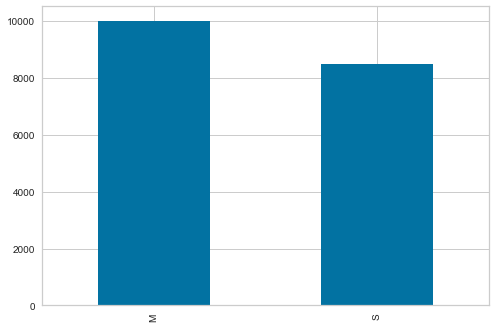

In [23]:
print("Count of the categories in the Marital_Status feature:\n",cst_df["MaritalStatus"].value_counts())
cst_df["MaritalStatus"].value_counts().plot(kind="bar")
plt.show()

Count of the categories in the Marital_Status feature:
 Bachelors              5356
Partial College        5064
High School            3294
Graduate Degree        3189
Partial High School    1581
Name: EnglishEducation, dtype: int64


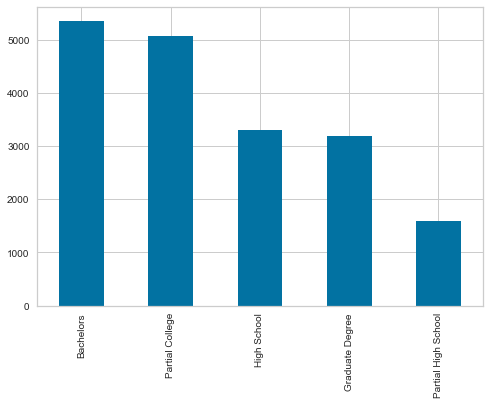

In [24]:
print("Count of the categories in the Marital_Status feature:\n",cst_df["EnglishEducation"].value_counts())
cst_df["EnglishEducation"].value_counts().plot(kind="bar")
plt.show()

Count of the categories in the Marital_Status feature:
 Professional      5520
Skilled Manual    4577
Management        3075
Clerical          2928
Manual            2384
Name: EnglishOccupation, dtype: int64


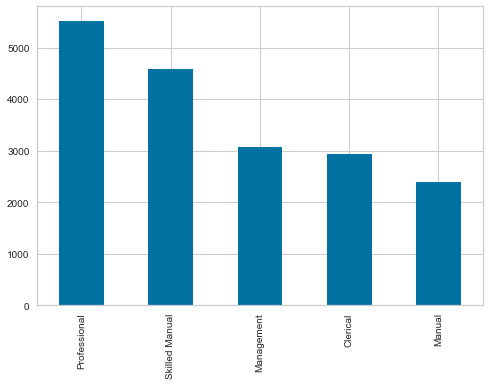

In [25]:
print("Count of the categories in the Marital_Status feature:\n",cst_df["EnglishOccupation"].value_counts())
cst_df["EnglishOccupation"].value_counts().plot(kind="bar")
plt.show()

Skilled Manual: a person whose job involves working with the hands.
Clerical:assigned to an office clerk or clerks
Manual:a person whose job involves physical work
Management:Management Occupations comprises the following occupations: Chief Executives; General and Operations etc
Professional: someone who derives their income from their specific knowledge or experience

In [26]:
cst_df["Year_Birth"]=cst_df["BirthDate"].apply(lambda x:int(x.split("-")[0]))

In [27]:
cst_df["Age"]=2014-cst_df["Year_Birth"]

In [28]:
drop_col=["BirthDate","MaritalStatus","TotalChildren","Gender","CommuteDistance","Year_Birth"]

In [29]:
cst_df=cst_df.drop(drop_col,axis=1)

In [30]:
cst_df.head()

,CustomerKey,YearlyIncome,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,DateFirstPurchase,Age
0,11000,90000.0,0,Bachelors,Professional,1,2011-01-19,43
1,11001,60000.0,3,Bachelors,Professional,0,2011-01-15,38
2,11002,60000.0,3,Bachelors,Professional,1,2011-01-07,43
3,11003,70000.0,0,Bachelors,Professional,0,2010-12-29,41
4,11004,80000.0,5,Bachelors,Professional,1,2011-01-23,35


Rfm of the customers are merged with the customers table

In [31]:
cst_rfm=cst_df.merge(rfm)

In [32]:
cst_rfm.rename(columns={"Monetary":"Total_Sales"},inplace=True)

In [33]:
cst_rfm

,CustomerKey,YearlyIncome,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,DateFirstPurchase,Age,Recency,Frequency,Total_Sales
0,11000,90000.0,0,Bachelors,Professional,1,2011-01-19,43,272,3,8248.9900
1,11001,60000.0,3,Bachelors,Professional,0,2011-01-15,38,51,3,6383.8800
2,11002,60000.0,3,Bachelors,Professional,1,2011-01-07,43,341,3,8114.0400
3,11003,70000.0,0,Bachelors,Professional,0,2010-12-29,41,265,3,8139.2900
4,11004,80000.0,5,Bachelors,Professional,1,2011-01-23,35,274,3,8196.0100
...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,30000.0,0,Graduate Degree,Clerical,1,2012-09-04,45,513,1,2049.0982
18480,29480,30000.0,0,Graduate Degree,Clerical,1,2013-07-17,37,197,1,2442.0300
18481,29481,30000.0,0,Graduate Degree,Clerical,0,2011-08-13,49,901,1,3374.9900
18482,29482,30000.0,0,Bachelors,Clerical,1,2012-09-18,50,499,1,2049.0982


In [34]:
cst_rfm["DateFirstPurchase"]=pd.to_datetime(cst_rfm["DateFirstPurchase"])

In [35]:
# First purchase and last purchase
present_date=dt.datetime(2014,1,30)


In [36]:
cst_rfm["First_Purchase"]=present_date-cst_rfm["DateFirstPurchase"]


In [37]:
cst_rfm.drop("DateFirstPurchase",axis=1,inplace=True)

In [38]:
cst_rfm["First_Purchase"]=cst_rfm["First_Purchase"].apply(lambda x: int(str(x).split(" ")[0]))

### Products Data

The products classified as products,product category and products sub category

In [143]:
# missing values in the products category is considered as other
pdc_df.loc[4]=[5,"Other"]

In [41]:
# Products subcategory is also having missing value so imputted with new value 
pd_df["ProductSubcategoryKey"].fillna(38,inplace=True)

In [42]:
pdsc_df.loc[37]=[38,"Other",5]

In [43]:
# Merging the all the products table and creating a new DataFrame
pd_ct_df=pdsc_df.merge(pdc_df,on="ProductCategoryKey",how="left")
product_tbl=pd_ct_df.merge(pd_df,on="ProductSubcategoryKey")

In [44]:
product_tbl

,ProductSubcategoryKey,EnglishProductSubcategoryName,ProductCategoryKey,EnglishProductCategoryName,ProductKey,ProductAlternateKey,EnglishProductName,EnglishDescription
0,1,Mountain Bikes,1,Bikes,344,BK-M82S-38,"Mountain-100 Silver, 38",Top-of-the-line competition mountain bike. Per...
1,1,Mountain Bikes,1,Bikes,345,BK-M82S-42,"Mountain-100 Silver, 42",Top-of-the-line competition mountain bike. Per...
2,1,Mountain Bikes,1,Bikes,346,BK-M82S-44,"Mountain-100 Silver, 44",Top-of-the-line competition mountain bike. Per...
3,1,Mountain Bikes,1,Bikes,347,BK-M82S-48,"Mountain-100 Silver, 48",Top-of-the-line competition mountain bike. Per...
4,1,Mountain Bikes,1,Bikes,348,BK-M82B-38,"Mountain-100 Black, 38",Top-of-the-line competition mountain bike. Per...
...,...,...,...,...,...,...,...,...
601,38,Other,5,Other,205,SS-2985,Seat Stays,NaN
602,38,Other,5,Other,206,ST-9828,Seat Tube,NaN
603,38,Other,5,Other,207,TO-2301,Top Tube,NaN
604,38,Other,5,Other,208,TP-0923,Tension Pulley,NaN


### Creating a DataFrame 

In [45]:
int_sales=int_sales.merge(product_tbl[["ProductKey","EnglishProductCategoryName"]])

In [46]:
int_sales["EnglishProductCategoryName"].value_counts()

Accessories    36092
Bikes          15205
Clothing        9101
Name: EnglishProductCategoryName, dtype: int64

<AxesSubplot:ylabel='Frequency'>

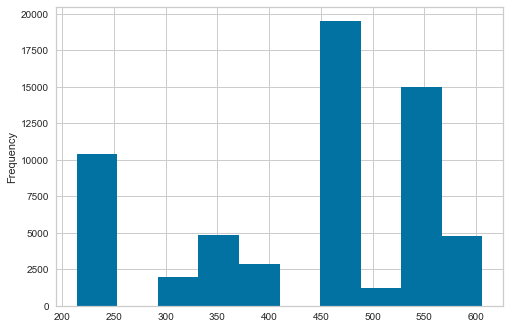

In [47]:
# There are 5 categories in the products table and we can see only 3 categories. To verify this we can plot a histogram
int_sales["ProductKey"].plot(kind="hist")

It`s clearly seen that there are missing values between 250 to 300 and 400 to 450. So this is the reason for getting only three Categories

# Grouping the different entries that correspond to the same user.

In [50]:
for i in int_sales["EnglishProductCategoryName"].unique():
    col=i+"_"
    x=int_sales.loc[int_sales["EnglishProductCategoryName"]==i].groupby(["CustomerKey"])["SalesAmount"].sum().reset_index(name=i+"_")
    cst_rfm=cst_rfm.merge(x,on="CustomerKey",how="left")
    try:
        cst_rfm[col]=(cst_rfm[col]/cst_rfm["Total_Sales"])*100
    except:
        cst_rfm[col]=0

In [52]:
transactions_per_user=int_sales.groupby("CustomerKey")["SalesAmount"].agg(["mean","min","max"]).reset_index()

cst_rfm=cst_rfm.merge(transactions_per_user)

In [53]:
cst_rfm

,CustomerKey,YearlyIncome,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,Age,Recency,Frequency,Total_Sales,First_Purchase,Bikes_,Accessories_,Clothing_,mean,min,max
0,11000,90000.0,0,Bachelors,Professional,1,43,272,3,8248.9900,1107,98.242936,1.102559,0.654504,1031.123750,4.9900,3399.9900
1,11001,60000.0,3,Bachelors,Professional,0,38,51,3,6383.8800,1111,97.667406,1.346047,0.986547,580.352727,4.9900,3374.9900
2,11002,60000.0,3,Bachelors,Professional,1,43,341,3,8114.0400,1119,99.568772,0.431228,NaN,2028.510000,34.9900,3399.9900
3,11003,70000.0,0,Bachelors,Professional,0,41,265,3,8139.2900,1128,99.259886,0.629662,0.110452,904.365556,2.2900,3399.9900
4,11004,80000.0,5,Bachelors,Professional,1,35,274,3,8196.0100,1103,98.877991,1.122009,NaN,1366.001667,21.9800,3399.9900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,30000.0,0,Graduate Degree,Clerical,1,45,513,1,2049.0982,513,100.000000,NaN,NaN,2049.098200,2049.0982,2049.0982
18480,29480,30000.0,0,Graduate Degree,Clerical,1,37,197,1,2442.0300,197,97.626565,2.005299,0.368136,488.406000,4.9900,2384.0700
18481,29481,30000.0,0,Graduate Degree,Clerical,0,49,901,1,3374.9900,901,100.000000,NaN,NaN,3374.990000,3374.9900,3374.9900
18482,29482,30000.0,0,Bachelors,Clerical,1,50,499,1,2049.0982,499,100.000000,NaN,NaN,2049.098200,2049.0982,2049.0982


In [54]:
cst_rfm["First_Purchase"].min()

2

In [55]:
cst_rfm["First_Purchase"].max()

1128

In [56]:
cst_rfm["Accessories_"].fillna(0,inplace=True)
cst_rfm["Clothing_"].fillna(0,inplace=True)
cst_rfm["Bikes_"].fillna(0,inplace=True)

One root cause of this approach is to find out the customer who had only one time purchased and objective would be targeting those customers and retaining them back

In [57]:
one_time_cst=cst_rfm.loc[cst_rfm["Frequency"]==1].shape[0]
total_cst=cst_rfm.shape[0]

print("The customer who had only one time purchase",one_time_cst/total_cst*100)

The customer who had only one time purchase 62.85977061242155


In [58]:
ref_data=cst_rfm.copy(deep=True)

### Encoding and Scaling the data

In [60]:
cst_rfm=pd.get_dummies(cst_rfm,prefix="dum")

In [61]:
df = cst_rfm.copy(deep = True)


In [62]:
df=df.drop("CustomerKey",axis=1)

In [63]:
matrix = df.values

In [64]:
matrix

array([[9.e+04, 0.e+00, 1.e+00, ..., 0.e+00, 1.e+00, 0.e+00],
       [6.e+04, 3.e+00, 0.e+00, ..., 0.e+00, 1.e+00, 0.e+00],
       [6.e+04, 3.e+00, 1.e+00, ..., 0.e+00, 1.e+00, 0.e+00],
       ...,
       [3.e+04, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [3.e+04, 0.e+00, 1.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [3.e+04, 0.e+00, 1.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [65]:
scaler = StandardScaler()
scaler.fit(matrix)
scaled_ds = pd.DataFrame(scaler.transform(matrix),columns= df.columns )

In [66]:
scaled_ds

,YearlyIncome,NumberChildrenAtHome,HouseOwnerFlag,Age,Recency,Frequency,Total_Sales,First_Purchase,Bikes_,Accessories_,...,dum_Bachelors,dum_Graduate Degree,dum_High School,dum_Partial College,dum_Partial High School,dum_Clerical,dum_Management,dum_Manual,dum_Professional,dum_Skilled Manual
0,1.012676,-0.659428,0.691725,-0.188676,0.551442,1.365555,3.135647,2.736672,1.021076,-0.853990,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,-0.433847,-0.44672,-0.384805,1.532498,-0.573685
1,0.083451,1.310862,-1.445661,-0.622108,-0.959310,1.365555,2.257607,2.751108,1.009311,-0.848563,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,-0.433847,-0.44672,-0.384805,1.532498,-0.573685
2,0.083451,1.310862,0.691725,-0.188676,1.023125,1.365555,3.072117,2.779982,1.048181,-0.868953,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,-0.433847,-0.44672,-0.384805,1.532498,-0.573685
3,0.393193,-0.659428,-1.445661,-0.362049,0.503590,1.365555,3.084003,2.812464,1.041867,-0.864530,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,-0.433847,-0.44672,-0.384805,1.532498,-0.573685
4,0.702935,2.624389,0.691725,-0.882167,0.565114,1.365555,3.110706,2.722235,1.034059,-0.853556,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,-0.433847,-0.44672,-0.384805,1.532498,-0.573685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,-0.845774,-0.659428,0.691725,-0.015303,2.198913,-0.450796,0.216917,0.592832,1.056997,-0.878565,...,-0.638735,2.190017,-0.465675,-0.614286,-0.305833,2.304960,-0.44672,-0.384805,-0.652529,-0.573685
18480,-0.845774,-0.659428,0.691725,-0.708794,0.038743,-0.450796,0.401898,-0.547662,1.008476,-0.833868,...,-0.638735,2.190017,-0.465675,-0.614286,-0.305833,2.304960,-0.44672,-0.384805,-0.652529,-0.573685
18481,-0.845774,-0.659428,-1.445661,0.331443,4.851274,-0.450796,0.841108,1.993185,1.056997,-0.878565,...,-0.638735,2.190017,-0.465675,-0.614286,-0.305833,2.304960,-0.44672,-0.384805,-0.652529,-0.573685
18482,-0.845774,-0.659428,0.691725,0.418129,2.103210,-0.450796,0.216917,0.542304,1.056997,-0.878565,...,1.565593,-0.456617,-0.465675,-0.614286,-0.305833,2.304960,-0.44672,-0.384805,-0.652529,-0.573685


### Dimensionality Reduction
In order to create the clusters of customers. Trying to reduce the columns using PCA which make the model bit more easy

In [67]:
pca = PCA()
pca.fit(scaled_ds)
pca_samples = pca.transform(scaled_ds)

In [68]:
pca_samples.shape

(18484, 24)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


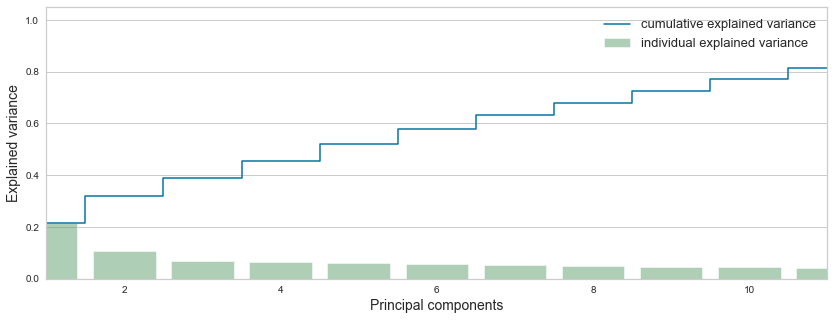

In [69]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

With 11 components the variance explained is 80%. So lets consider 11 columns

In [70]:
pca = PCA(0.80)
pca.fit(scaled_ds)
df_80_var = pca.transform(scaled_ds)

In [71]:
df_80_var.shape

(18484, 11)

## Model_Building


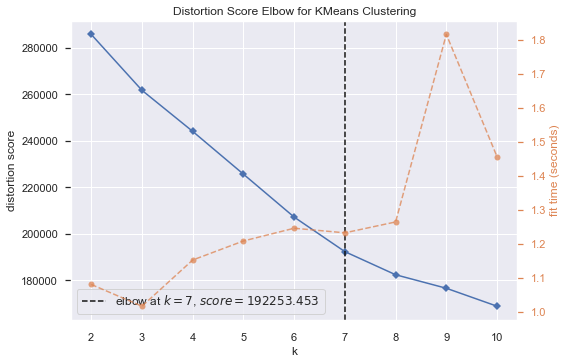

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_80_var)
Elbow_M.show()

The above plot is trying to explain that 7 will be the optimal number of clusters of this data

In [77]:
range_n_clusters=[i for i in range(3,11)]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_80_var)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_80_var, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.143799492193939
For n_clusters = 4 The average silhouette_score is : 0.15771506215352288
For n_clusters = 5 The average silhouette_score is : 0.16295735135208791
For n_clusters = 6 The average silhouette_score is : 0.16303762577775943
For n_clusters = 7 The average silhouette_score is : 0.19572725656143938
For n_clusters = 8 The average silhouette_score is : 0.18792980687135596
For n_clusters = 9 The average silhouette_score is : 0.20004877211528915
For n_clusters = 10 The average silhouette_score is : 0.208892641805954


The quality of the Clusters predicted is measured using silhouette score. For the cluster 7 the silhouette score is high compartively

In [78]:
n_clusters = 7
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(df_80_var)
clusters_clients = kmeans.predict(df_80_var)
silhouette_avg = silhouette_score(df_80_var, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.196


In [79]:
clusters=pd.DataFrame(clusters_clients,columns=["Cluster"])

In [80]:
ref_data["Clusters"]=clusters["Cluster"]

# Evaluating the Model

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


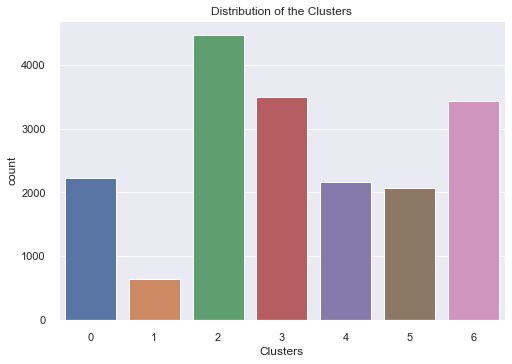

In [81]:
dst_cl=sns.countplot(ref_data["Clusters"])
dst_cl.set_title("Distribution of the Clusters")
plt.show()

## Evalution of these model is made as report using Power Bi.

#### These are the insights made out of the report.

Cluster_0 
- This cluster belongs to the customers whose occupation are **Clerical**. 
 The products category on which these customers interests are Clothing and Accessories.
 Customers whose recency is less are having more frequency.

Cluster_1
- These customers are those customers who are more interested into **Bikes**. The frequency of these customers are less might because as they are totally into spending on bikes, basically people don’t buy bikes too often than that of accessories and clothing. 

Cluster_2
- This cluster is a generalized cluster where there is no bias towards any particular occupation.
The product category on which these customers where interested are Bikes. 72% of customers who spent on bikes falls into this cluster.
For the past 6 months the purchase frequency of these customers are increasing.
Most of the Customers under these category are high spending.

Cluster_3
- This cluster belongs to the customers whose occupation are **Professionals**.
The product category on which these customers mostly spent is Clothing. As most of their spending is on clothing the customer recency is low and frequency is high.

Cluster_4
- This cluster belongs to the customers whose occupation are **Management**.
The products category on which these customers where interested in are Accessories and Clothing.
Amount they invested on sales is below 5000. As they are investing on both Clothes and Accessories, Frequency of these customers is more. 

Cluster_5
- This cluster belongs to the customers whose occupation are **Manual** and also low earning customers. 
Frequency of these customers is less but the purchase amount is high. These customers are one time buyers.
The product category on which these customers mostly spent is Accessories.

Cluster_6 
- This cluster belongs to the customers whose occupation are **Skilled Manual**.
The Product category on which these customers mostly spent are Clothing.

Overall from the given data we can see one thing in common for the past 6 months there was a huge increase in the sales.
